In [1]:
import torch
import torch.nn as nn

from models.kinematic_model.kinematic_model import KinematicModel
from models.timing_model.timing_model import TimingModel
from models.spatial_model.spatial_model import SpatialModel
from models.robot_visualizer.robot_visualizer import RobotVisualizer
import task_specifications.tasks as tasks
import task_specifications.utils.operation_types as operation_types

In [2]:
km = KinematicModel()
tm = TimingModel()
sm = SpatialModel()
rv = RobotVisualizer()

In [3]:
# helper function to generate joint position given grid position
def grid_to_joint_position(grid_position):
	x, y, z = grid_position
	return km.compute_inverse_kinematics(sm.compute_spatial_pose(x, y, z))

In [4]:
def generate_timed_task_matrix(task, initial_grid_position):
	x, y, z = initial_grid_position
	start_joint_position = grid_to_joint_position((x, y, z))
	task_matrix = []
	for operation in task:
		if isinstance(operation, operation_types.Move):
			x_t, y_t, z_t= operation.x, operation.y, operation.table_distance
			joint_position = grid_to_joint_position((x_t, y_t, z_t))
			time = tm.compute_duration_between_jps(start_joint_position, joint_position)
			task_matrix.append([*start_joint_position, *joint_position, time])
			start_joint_position = joint_position
		elif isinstance(operation, operation_types.Grip):
			task_matrix.append([*start_joint_position, *start_joint_position, 1.1])
		elif isinstance(operation, operation_types.MoveGripper):
			task_matrix.append([*start_joint_position, *start_joint_position, 1.1])

	return task_matrix    

In [5]:
import torch

class Trajectory:
    def __init__(self, name, time, positions, velocities, accelerations, istime):
        self.name = name
        self.time = time
        self.positions = positions
        self.velocities = velocities
        self.accelerations = accelerations
        self.istime = istime

def jtraj(q0, qf, t, qd0=None, qd1=None):
	"""
	Compute a joint-space trajectory using a quintic polynomial for time scaling.

	:param q0: initial joint coordinate (torch tensor)
	:param qf: final joint coordinate (torch tensor)
	:param t: time vector or number of steps (int or torch tensor)
	:param qd0: initial velocity (torch tensor), defaults to zero
	:param qd1: final velocity (torch tensor), defaults to zero
	:return: Trajectory object containing position, velocity, and acceleration
	"""
	t = t.clone()
	ts = torch.linspace(0, 1, int(t.item()))
	tv = ts * t

    # q0 = q0.flatten()
    # qf = qf.flatten()

    # If velocities are not provided, assume zero velocity at start and end
	if qd0 is None:
		qd0 = torch.zeros_like(q0)
	if qd1 is None:
		qd1 = torch.zeros_like(qf)

	# Compute polynomial coefficients
	A = 6 * (qf - q0) - 3 * (qd1 + qd0) 
	B = -15 * (qf - q0) + (8 * qd0 + 7 * qd1) 
	C = 10 * (qf - q0) - (6 * qd0 + 4 * qd1) 
	E = qd0 
	F = q0

	# Construct the matrix of powers of time (t^5, t^4, ..., t^0)
	tt = torch.stack([ts**5, ts**4, ts**3, ts**2, ts, torch.ones_like(ts)], dim=0).T
	coeffs = torch.stack([A, B, C, torch.zeros_like(A), E, F], dim=0)

	qt = torch.matmul(tt, coeffs)  # (N x 6)

	# Compute velocity (derivative of position)
	coeffs_vel = torch.stack([torch.zeros_like(A), 5 * A, 4 * B, 3 * C, torch.zeros_like(A), E], dim=0)
	qdt = torch.matmul(tt, coeffs_vel) / (tv.max()-tv.min())  # Divide by total time to scale the velocity

	# Compute acceleration (second derivative of position)
	coeffs_acc = torch.stack([torch.zeros_like(A), torch.zeros_like(A), 20 * A, 12 * B, 6 * C, torch.zeros_like(A)], dim=0)
	qddt = torch.matmul(tt, coeffs_acc) / (tv.max()-tv.min())**2  # Divide by time squared to scale the acceleration

	# Return a Trajectory object
	return Trajectory("jtraj", tv, qt, qdt, qddt, istime=True)

In [66]:
def generate_trajectory(timed_task_matrix):
    trajectory = []
    for op in timed_task_matrix:
        # start = op[:6].requires_grad_(True)
        # end = op[6:12].requires_grad_(True)
        # t = op[12].requires_grad_(True)
        start = op[:6]
        end = op[6:12]
        t = op[12]
        no_steps = t/0.05
        # no_steps = torch.floor(t/0.05).to(torch.int32)
        # 'no_steps = int(t.item()/0.05)'
        # no_steps = int(t/0.05)
        trajectory_segment = jtraj(start, end, no_steps)
        trajectory.append(trajectory_segment.positions)
    a = torch.cat(trajectory, dim=0)
    return a
    # return torch.cat(trajectory, dim=0)

In [56]:
# example task
task = tasks.two_blocks

# generate timed task matrix
timed_task_matrix = torch.tensor(generate_timed_task_matrix(task, (0,0,0)), dtype=torch.float32, requires_grad=True)
# timed_task_matrix_noisy = timed_task_matrix.clone()
timed_task_matrix_noisy = torch.tensor(generate_timed_task_matrix(task, (0,0,0)), dtype=torch.float32, requires_grad=True)

# zero matrix except for the time column which is noisy
noise = torch.zeros_like(timed_task_matrix_noisy)
noise[:, 12] = torch.abs(torch.randn_like(timed_task_matrix[:, 12]) * 0.1)
timed_task_matrix_noisy = timed_task_matrix_noisy + noise
timed_task_matrix_noisy = timed_task_matrix_noisy.detach()

# timed_task_matrix_noisy[:, 12] = timed_task_matrix_noisy[:, 12] + torch.abs(torch.randn_like(timed_task_matrix[:, 12]) * 0.1)

# generate trajectory
trajectory_noisy = generate_trajectory(timed_task_matrix_noisy)
trajectory = generate_trajectory(timed_task_matrix)

In [57]:
# print shape and type info
print("timed_task_matrix shape: ", timed_task_matrix.shape)
print("timed_task_matrix type: ", timed_task_matrix.dtype)
print("trajectory shape: ", trajectory_noisy.shape)
print("trajectory_noisy type: ", trajectory_noisy.dtype)

timed_task_matrix shape:  torch.Size([16, 13])
timed_task_matrix type:  torch.float32
trajectory shape:  torch.Size([365, 6])
trajectory_noisy type:  torch.float32


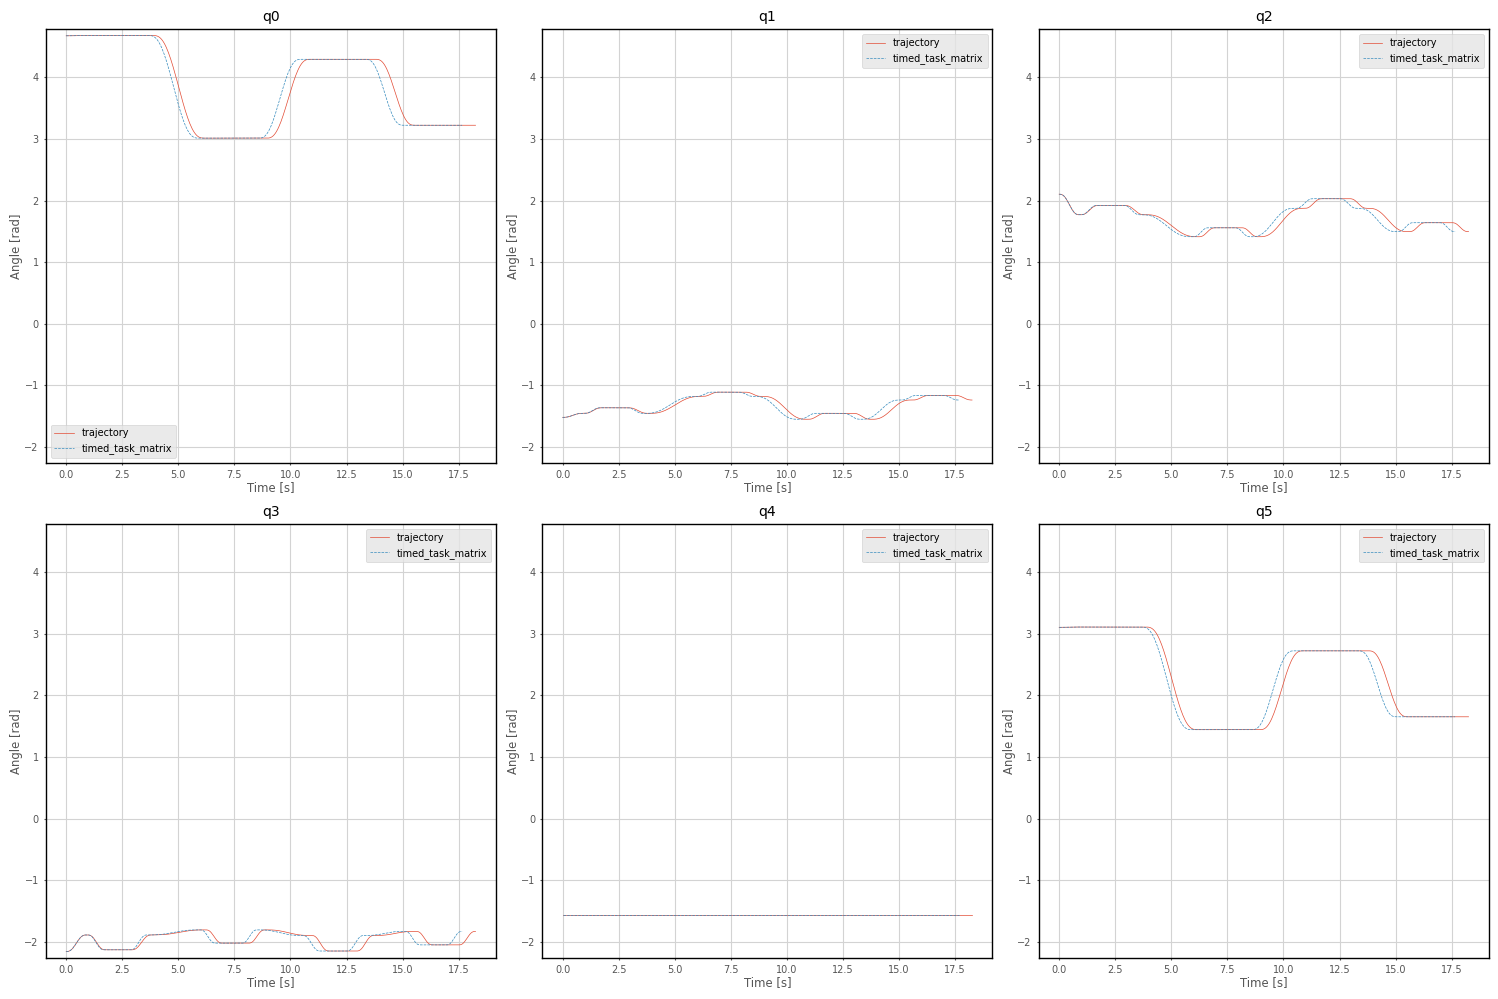

In [58]:
# plot
rv.plot_trajectory_2d([trajectory_noisy.detach().numpy(), trajectory.detach().numpy()], ["trajectory", "timed_task_matrix"])

In [59]:
# see if leaf
print("timed_task_matrix is leaf: ", timed_task_matrix.is_leaf)
print("trajectory_noisy is leaf: ", trajectory_noisy.is_leaf)
print("trajectory is leaf: ", trajectory.is_leaf)

timed_task_matrix is leaf:  True
trajectory_noisy is leaf:  True
trajectory is leaf:  False


In [60]:
class TimingOffsetModel(nn.Module):
	def __init__(self, input_size=13, hidden_size=64):
		super(TimingOffsetModel, self).__init__()
		# First fully connected layer (input to hidden layer)
		self.fc1 = nn.Linear(input_size, hidden_size)
		self.relu = nn.ReLU()  # ReLU activation for non-linearity

		self.fc3 = nn.Linear(hidden_size, hidden_size*2)
		self.fc4 = nn.Linear(hidden_size*2, hidden_size*4)

		# Second fully connected layer (hidden to output layer)
		self.fc2 = nn.Linear(hidden_size*4, 1)  # Output is a single value (offset)

		self.init_weights()

	def trajectory_generation(self, timed_task_matrix, offsets):
		# add offset to the time column
		# timed_task_matrix_ = timed_task_matrix.clone()
		# timed_task_matrix_[:, 12]  = timed_task_matrix_[:, 12] + offsets.squeeze()
		# zero matrix with offsets in the last column
		offsets_ = torch.zeros_like(timed_task_matrix)
		offsets_[:, 12] = offsets.squeeze()
		timed_task_matrix = timed_task_matrix + offsets_

		return generate_trajectory(timed_task_matrix)

	def forward(self, x):
		# Apply first layer and ReLU activation
		input = x
		x = self.fc1(x)
		x = self.relu(x)
		x = self.fc3(x)
		x = self.relu(x)
		x = self.fc4(x)
		x = self.relu(x)
		x = self.fc2(x)
		# x = self.relu(x)  # Ensure the offset is positive
		x = torch.abs(x + 0.1)  # Ensure the offset is positive

		return self.trajectory_generation(input, x)
	
	def init_weights(self):
		# Initialize weights using Xavier initialization
		for m in self.modules():
			if isinstance(m, nn.Linear):
				nn.init.xavier_normal_(m.weight)

In [68]:
def train_model(model, criterion, optimizer, timed_task_matrix, trajectory_noisy, num_epochs=1000):
    # Ensure both data and model are on the same device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    timed_task_matrix = timed_task_matrix.to(device)
    trajectory_noisy = trajectory_noisy.to(device)
    
    for epoch in range(num_epochs):
        # Forward pass
        output = model(timed_task_matrix)

        # Ensure trajectory lengths match
        with torch.no_grad():
            min_len = min(output.size(0), trajectory_noisy.size(0))
            trajectory_noisy_slices = trajectory_noisy[:min_len]
        output_slices = output[:min_len]
                
        # Compute the loss
        loss = criterion(output_slices, trajectory_noisy_slices)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward(retain_graph=True)  # Ensure the graph is retained if needed
        optimizer.step()
    
        # Output the loss for every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')
            # print gradients
            # for name, param in model.named_parameters():
                # print(f'{name} grad: {param.grad.norm()}') if param.grad is not None else None

# Train the model
model = TimingOffsetModel(input_size=13, hidden_size=64)
for name, param in model.named_parameters():
    print(f'{name} is leaf: {param.is_leaf}')

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
train_model(model, criterion, optimizer, timed_task_matrix, trajectory_noisy, num_epochs=100)


fc1.weight is leaf: True
fc1.bias is leaf: True
fc3.weight is leaf: True
fc3.bias is leaf: True
fc4.weight is leaf: True
fc4.bias is leaf: True
fc2.weight is leaf: True
fc2.bias is leaf: True
Epoch 10/100, Loss: 0.11535080522298813
Epoch 20/100, Loss: 0.11535080522298813
Epoch 30/100, Loss: 0.11535080522298813
Epoch 40/100, Loss: 0.11535080522298813
Epoch 50/100, Loss: 0.11535080522298813
Epoch 60/100, Loss: 0.11535080522298813
Epoch 70/100, Loss: 0.11535080522298813
Epoch 80/100, Loss: 0.11535080522298813
Epoch 90/100, Loss: 0.11535080522298813
Epoch 100/100, Loss: 0.11535080522298813


1


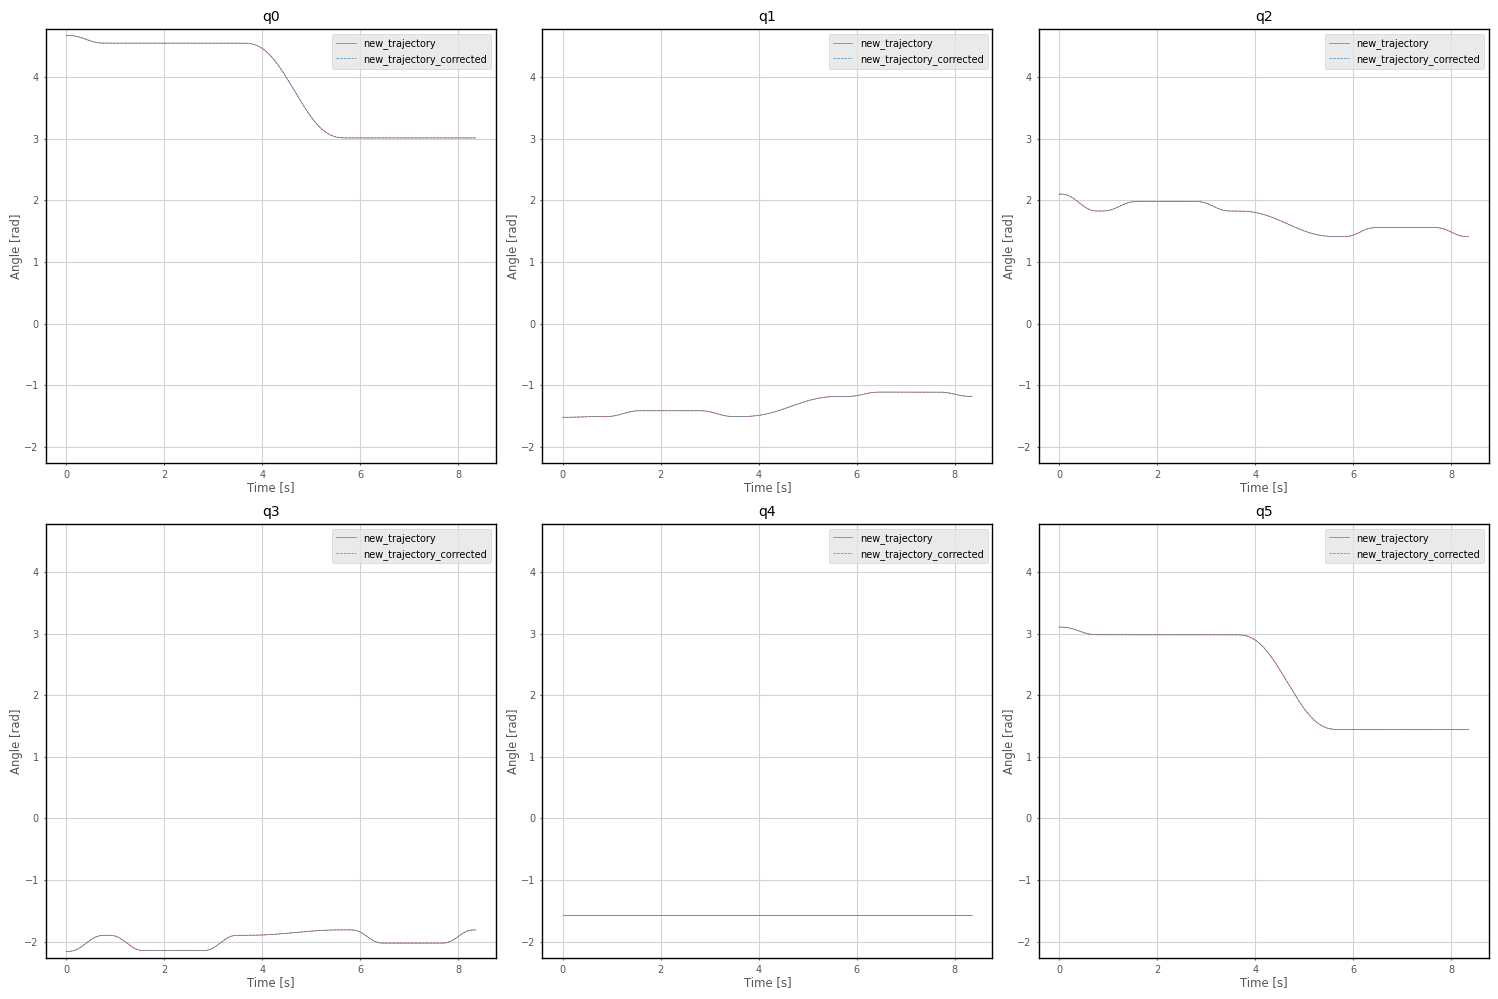

In [13]:
# plot
model.eval()

new_task = tasks.one_block
print(new_task[0].x)
new_timed_task_matrix = torch.tensor(generate_timed_task_matrix(new_task, (0,0,0)), dtype=torch.float32, requires_grad=True)
new_trajectory = generate_trajectory(new_timed_task_matrix)

new_trajectory_corrected = model(new_timed_task_matrix)
rv.plot_trajectory_2d([new_trajectory.detach().numpy(), new_trajectory_corrected.detach().numpy()], ["new_trajectory", "new_trajectory_corrected"])